# $Q_\mathrm{pr}$ Table Generation
(Made by Yoonsoo P. Bach)

In [1]:
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

This notebook was generated at 2019-10-17 12:08:04 (KST = GMT+0900) 


This notebook is made to show how I

1. "organized" the optical indices data from references
2. did Mie calculation to get the $Q_\mathrm{pr}$ 
  * I used prof. Scott Prahl's [``miepython`` (commit on 2019-02-12)](https://github.com/scottprahl/miepython)

and will display some informative plots to explain our modeling.

Here I used the notation that $Q_\mathrm{pr}$ is the radiation pressure coefficient, $ \bar{Q}_\mathrm{pr} $ is the black-body spectrum averaged value of $Q_\mathrm{pr}$. The black-body radiance function is $B_\lambda$ (the Planck function) and $b_\lambda$ is the energy-normalized emission radiance function, i.e., $ \epsilon(\lambda) B_\lambda(\lambda, T) / \int_{0}^{\infty} \epsilon(\lambda) B_\lambda(\lambda, T) d\lambda = (\pi \epsilon(\lambda) / \bar{\epsilon}(\epsilon) \sigma_\mathrm{SB} T^4) B_\lambda(\lambda, T) $, which thus have the unit of inverse length.

## 1. Data Sources

### 1-1. Olivine
I adopted data from [link](https://www.astro.uni-jena.de/Laboratory/OCDB/crsilicates.html) and combined the following two data tables:

**Low-Fe olivine (natural)**, $\mathrm{Mg_{1.9} Fe_{0.1} Si O_4}$ (Fabian et al. 2001, Zeidler et al. 2011) 
* Olivine (Stubachtal) in the Mid/Far IR (oriented)
* Olivine (Stubachtal) in the UV-VIS-NIR (non-oriented, unpublished)

Then I added ``"#"`` to all the comment linkes.

### 1-2. Magnetite
I adopted data from [link](https://www.astro.uni-jena.de/Laboratory/OCDB/mgfeoxides.html#C) with title

``Iron oxides, created by Amaury H.M.J. Triaud, (Amaury.Triaud@obs.unige.ch) unpublished`` ($\mathrm{Fe_3 O_4}$).

There was no comment nor unrealistic value, so it's much easier to handle than olivine case as shown below.

## 2. Importing and Setting up

In [2]:
%load_ext version_information
vv = %version_information scipy, numpy, matplotlib, pandas, miepython, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

0 Python     3.7.3 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    7.7.0
2 OS         Darwin 18.7.0 x86_64 i386 64bit
3 scipy      1.3.1
4 numpy      1.16.4
5 matplotlib 3.1.0
6 pandas     0.24.2
7 miepython  1.3.0
8 version_information 1.0.3


In [1]:
from IPython.display import clear_output

from pathlib import Path
from multiprocessing import Pool

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import LogLocator, MultipleLocator, FormatStrFormatter, LogFormatter

import miepython as mp
import yssbtmpy as tm
from accutil import linticker, logyticker, logticker, logxticker
from scipy.integrate import trapz

def multi_Qpr(wl, m, r):
    ''' Mie calculation for multithreading, wl and r in identical unit.
    '''
    x = 2 * np.pi * r / wl
    Qext, Qsca, Qback, g = mp.mie(m, x)
    Qpr = Qext - g * Qsca
    return Qpr


def multi_Qprbar(wl, Qpr_2d, temp):
    ''' Qprbar calculation for multithreading, wl in μm and temp in K.
    '''
    # using np.newaxis helped from
    # https://stackoverflow.com/questions/18522216/multiplying-across-in-a-numpy-array/18522281#18522281
    blam = tm.b_lambda(wl, temp)[:, np.newaxis]

    bQpr = blam * Qpr_2d
    dwl = np.ediff1d(wl)
    Qprbar = trapz(y=bQpr, x=wl, dx=dwl, axis=0)
    return Qprbar


fname_mag = "Qpr_mag.csv"
fname_oliv = "Qpr_oliv_{:s}.csv"

DATAPATH = Path("./data")
savedir = DATAPATH / "Qpr"
figdir = Path("figs")

# define constants (All in SI unit!!!)
PI = np.pi
D2R = PI / 180

c_T_sun = tm.T_SUN  # BB temp of the Sun
c_h = tm.HH         # Planck constant
c_kB = tm.KB        # Boltzman constant
c_SB = tm.SIGMA_SB  # Stefan--Boltzmann constant
c_c = tm.CC         # Speed of light
c_um = 1.e-6        # 1 μm in SI

radii = np.concatenate([np.arange(0.1, 2, 0.1),
                        np.arange(2.0, 10, 1),
                        np.arange(10, 100, 10),
                        np.arange(100, 1001, 100)])
calctemps = np.arange(10, 1301, 1)
plotradii = [0.1, 1.0, 2.0, 10, 100]
plot_temps = [c_T_sun, 1000, 300, 100, 10]

In [2]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

#### NOTE: ``miepython`` version

There was a bug in ``miepython`` prior to 2019-02-07 UT, when calculating for large sphere (see [the issue](https://github.com/scottprahl/miepython/issues/4)). It is now resolved, and the developer (Scott Prahl) kindly made a notebook with testing cases (see by [GitHub](https://github.com/scottprahl/miepython/blob/master/doc/08_large_spheres.ipynb) or [nbviewer](https://nbviewer.jupyter.org/github/scottprahl/miepython/blob/master/doc/08_large_spheres.ipynb)).

## 3. Mie Calculations

The Mie calculation is used to obtain $Q_\mathrm{pr}$, the radiation pressure coefficient, and $ \bar{Q}_\mathrm{pr} $, the black-body spectrum averaged value of $Q_\mathrm{pr}$. 

### 3-1. Olivine

The olivine data are composed of 

1. randomly oriented version in visible (wavelength 0.199878 to 1.981843 [μm] or wave number of 5045.8... to 50030.4... [1/cm])
2. x/y/z oriented version in IR (wavelength 2.0 to 4096.68... [μm] or wave number of 2.441 to 4999.987 [1/cm])

Thus, for each of the x/y/z oriented version of IR, I attached (concatenated) the identical visible data. 

For wavelength < 0.2 μm = 200 nm, no data was there, so I put a constant: $Q_\mathrm{pr} = 1$.
  * Although it is a crude approximation, but anyway the spectral flux from wavelength < 0.2 μm is always very tiny for all the temperature range of interest ($T < T_\mathrm{sun} \sim 5777$K), so it is not a big problem.
Olivine data files contain the 0-th rows as wave number = 0. I ignored this point.

In [5]:
wl_low = np.arange(0.100, 0.199, 0.001)
Qpr_extrapolate = 1.

colnames = ["wavenum", "mr", "mi"]

for xyz in ["x", "y", "z"]:
    savepath = savedir / fname_oliv.format(xyz)

    if not savepath.exists():
        data_v_raw = np.loadtxt(DATAPATH / "oliv_vis.txt", comments='#', delimiter='\t')
        data_v = pd.DataFrame(data_v_raw, columns=colnames)
        data_ir_raw = np.loadtxt(DATAPATH / f"oliv_nk_{xyz}.txt", comments='#')    
        data_ir = pd.DataFrame(data_ir_raw, columns=colnames)
        data_ir.drop(0, axis=0, inplace=True)  # the wavenum == 0 is removed.

        data_orig = pd.concat([data_ir, data_v])
        data_orig["wavelength"] = (1 / data_orig["wavenum"]) * 1.e+4  # in μm unit
        data_orig.sort_values('wavelength', inplace=True)

        Qpr_oliv_xyz = {}

        wl_orig = np.array(data_orig["wavelength"])
        mr = np.array(data_orig["mr"])
        mi = np.array(data_orig["mi"])
        m = mr - 1.0j * mi

        Qpr_oliv_xyz["wavelength"] = wl_orig
        
        pool = Pool(20)
        args = np.array([[wl_orig]*len(radii), [m]*len(radii), radii]).T
        Qpr = pool.starmap(multi_Qpr, args)
        pool.close()

        for i, r in enumerate(radii):  # radius in μm
            Qpr_oliv_xyz[f"{r:.1f}"] = np.array(Qpr)[i,:]
        
        Qpr_oliv_xyz = pd.DataFrame(Qpr_oliv_xyz)
        # put fake data s.t. Qpr = 1.00 for 50 nm < wl < 190 nm
        lower_wavelen = pd.DataFrame(Qpr_extrapolate, 
                                     index=np.arange(wl_low.shape[0]), 
                                     columns=Qpr_oliv_xyz.columns)
        lower_wavelen["wavelength"] = wl_low
        Qpr_oliv_xyz = pd.concat([lower_wavelen, Qpr_oliv_xyz])
        Qpr_oliv_xyz.sort_values('wavelength', inplace=True)  # Just in case..

        Qpr_oliv_xyz.to_csv(savepath, index=False)

        # It was annoying when I was debugging, so deleted these...:
        del Qpr, m, mr, mi, Qpr_oliv_xyz, wl_orig


It took about 7 min for each of x/y/z on my laptop (MBP2018 15") when using 20 threads (4 times speed gain than single thread). This is a one-time calculation, so I didn't put effort to make it faster (e.g., suggesting to use numba in ``miepython``)

If you don't want multithreading, use the following code instead of ``pool``.
```python
        for i, r in enumerate(radii):  # radius in μm
            clear_output(wait=True)
            print(savepath)
            print(f"{i+1} of {len(radii)}, {xyz}")
            
            x = 2 * np.pi * r / wl_orig
            Qext, Qsca, Qback, g = mp.mie(m, x)
            Qpr = Qext - g * Qsca
            Qpr_oliv_xyz[f"{r:.1f}"] = Qpr
        Qpr_oliv_xyz = pd.DataFrame(Qpr_oliv_xyz)
        Qpr_oliv_xyz.to_csv(savepath, index=False)

```

### 3-2. Magnetite

The magnetite data is a single ``.dat`` file covering wavelength from 0.1 to 1000 [μm]. It is not written in the data file, but from the figure they provided ([link](https://www.astro.uni-jena.de/Laboratory/OCDB/300/magnetit1.jpg)) and compare it with the 0-th column of the data, you can understand it is in wavelength, not in wavenumber. Thus, I directly fed the 0-th column to ``miepython`` as wavelength.

For magnetite, the minimum wavelength is already 0.1 μm, I did not extrapolate it to lower wavelength.

Because the complex optical index is given only upto 1000 μm = 1mm, it is **not** plausible to do Mie calculation of particles larger than around 0.1 mm. Just for a simpler comparison with olivine, I ran the calculation upto the radius of 1mm. Therefore, please note that _the results of magnetite with size larger than around 100 μm is unreliable_. 
  * The $ Q_\mathrm{pr} $ value gets very small as wavelength gets much larger than the particle size (Rayleigh regime). Since the particle sizes of interest are ony up to around 100 μm = 0.1 mm (although I ran calculation up to particle size of 1 mm for test), this is also not a big matter. Moreover, our work have shown that only the particles $\lesssim$ 10 μm are able to be affected critically by thermal radiation force (e.g., for (3200) Phaethon case). For this long wavelength range, a more important factor is the wavelength dependence of the emissivity, which is out of the scope of this study.


In [6]:
data_mag = pd.DataFrame(np.loadtxt(DATAPATH / f"mag_nk.dat"),
                        columns=["wavelength", "mr", "mi"])

savepath = savedir / fname_mag

if not savepath.exists():
    Qpr_mag = {"wavelength":data_mag["wavelength"]}
    m = data_mag["mr"] - 1.0j * data_mag["mi"]
    wl_orig = np.array(data_mag["wavelength"])
    pool = Pool(20)
    args = np.array([[wl_orig]*len(radii), [m]*len(radii), radii]).T
    Qpr = pool.starmap(multi_Qpr, args)
    pool.close()

    for i, r in enumerate(radii):  # radius in μm
        Qpr_mag[f"{r:.1f}"] = np.array(Qpr)[i,:]
        
    Qpr_mag = pd.DataFrame(Qpr_mag)
    Qpr_mag.to_csv(savepath, index=False)
        
    del Qpr_mag, wl_orig, Qpr, m

It took about 45 sec on my laptop (MBP2018 15") for multithreading of 20 (5 times speed gain compared to single thread)

If you don't want multithreading, use the following code inside the ``if not savepath.exists()`` clause.
```python
    for i, r in enumerate(radii):  #radius in microns
        clear_output(wait=True)
        print(savepath)
        print(f"{i+1} of {len(radii)}")

        x = 2 * np.pi * r / data_mag["wavelength"]
        m = data_mag["mr"] - 1.0j * data_mag["mi"]
        Qext, Qsca, Qback, g = mp.mie(m, x)
        Qpr = Qext - g * Qsca
        Qpr_mag[f"{r:.1f}"] = Qpr

    Qpr_mag = pd.DataFrame(Qpr_mag)
    Qpr_mag.to_csv(savepath, index=False)
```

## 4. Getting $\bar{Q}_{\mathrm{pr}}$ (``Qprbar``)

I will now calculate $\bar{Q}_\mathrm{pr}$ from $Q_\mathrm{pr}$ values. Note that $\bar{Q}_\mathrm{pr} = \bar{Q}_\mathrm{pr} (T, a, \epsilon)$, where $T, a, \epsilon$ are the black body temperature, particle radius, and emissivity function (as wavelength). Here we assume $\epsilon = \bar{\epsilon} = \mathrm{const} $, $\bar{Q}_\mathrm{pr} = \bar{Q}_\mathrm{pr} (T, a)$. I made two different arrays.

1. ``N_temp`` x ``N_radii`` array which contains $\bar{Q}_\mathrm{pr}$ for the possible temperatures of surface regolith. 
  * For surface temperature, I used $ T \in [10, 1300]$ [K] with 1 K interval.
  * It will be used to make $\bar{Q}_\mathrm{pr}$ function using a spline interpolation to these values.
2. ``1`` x ``N_radii`` array which contains $\bar{Q}_\mathrm{pr}$ for $T = T_\odot = 5777 \mathrm{K}$.
  * A spline interpolation will be done to get $\bar{Q}_\mathrm{pr, \odot}$ for given radius.
  
These will be saved as csv format such that the 0-th column is the temperature (``"T"``), and other columns are radii, so that each column means the $\bar{Q}_\mathrm{pr}$ value as a function of temperature.


In [7]:
# Define two convenience functions...
def Qpr_extractor(fpath, col0="wavelength"):
    Qpr_data = pd.read_csv(fpath)
    columns = Qpr_data.columns[1:]  # 0-th is wavelength for Qpr, temperature for Qprbar.
    col_0 = Qpr_data[col0]
    Qpr_data = Qpr_data.values[:, 1:]  # 0-th is wavelength, temperature for Qprbar.
    return col_0, Qpr_data, columns

def Qprbar_df_maker(Qprbar, columns, temps, output):
    Qprbar_df = pd.DataFrame(np.atleast_2d(Qprbar), columns=columns)
    Qprbar_df.insert(loc=0, value=temps, column="T")
    Qprbar_df.to_csv(output, index=False)
    return Qprbar_df

### 4-1. Olivine

In [8]:
Qprbar2stack = {"Qprbar_oliv": dict(T=calctemps, arr2stack=[]),
                "Qprbar_sun_oliv": dict(T=c_T_sun, arr2stack=[])}

for xyz in ["x", "y", "z"]:
    wl, Qpr_oliv_xyz, columns = Qpr_extractor(savedir / fname_oliv.format(xyz))

    # For 10 - 1300 K
    pool = Pool(50)
    args = np.array([[wl*c_um]*len(calctemps), 
                     [Qpr_oliv_xyz]*len(calctemps), 
                     calctemps
                    ]
                   ).T
    Qprbar_oliv_xyz = pool.starmap(multi_Qprbar, args)
    pool.close()
    
    Qprbar2stack["Qprbar_oliv"]["arr2stack"].append(np.array(Qprbar_oliv_xyz))
    Qprbar_oliv_xyz = Qprbar_df_maker(Qprbar_oliv_xyz, 
                                      columns=columns, 
                                      temps=calctemps,
                                      output=savedir / f"Qprbar_oliv_{xyz}.csv")
    
    # For Sun (c_T_sun = 5777 K)
    Qprbar_sun_oliv_xyz = multi_Qprbar(wl=wl * c_um,
                                       Qpr_2d=Qpr_oliv_xyz,
                                       temp=c_T_sun)
    Qprbar2stack["Qprbar_sun_oliv"]["arr2stack"].append(np.array(Qprbar_sun_oliv_xyz))
    Qprbar_sun_oliv_xyz = Qprbar_df_maker(Qprbar_sun_oliv_xyz,
                                          columns=columns,
                                          temps=c_T_sun,
                                          output=savedir / f"Qprbar_sun_oliv_{xyz}.csv")

As explained in Section 5-1, the x/y/z orientation does not give much difference in $\bar{Q}_\mathrm{pr}$ value, and thus I ignored their difference and used the average value of these three orientations. For future reference, I saved the average of these:

In [9]:
for k, v in Qprbar2stack.items():
    Qprbar_avg = np.mean(v["arr2stack"], axis=0)
    Qprbar_avg = Qprbar_df_maker(Qprbar_avg,
                                 columns=columns,
                                 temps=v["T"],
                                 output=savedir / f"{k}.csv")

### 4-2. Magnetite

In [10]:
wl, Qpr_mag, columns = Qpr_extractor(savedir / fname_mag)

# For 10 - 1300 K
pool = Pool(50)
args = np.array([[wl*c_um]*len(calctemps), 
                 [Qpr_mag]*len(calctemps), 
                 calctemps
                ]
               ).T
Qprbar_mag = pool.starmap(multi_Qprbar, args)
pool.close()

Qprbar_mag = Qprbar_df_maker(Qprbar_mag,
                            columns=columns,
                            temps=calctemps,
                            output=savedir / "Qprbar_mag.csv")

# For Sun (c_T_sun = 5777 K)
Qprbar_sun_mag = multi_Qprbar(wl=wl * c_um,
                              Qpr_2d=Qpr_mag,
                              temp=c_T_sun)

Qprbar_sun_mag = Qprbar_df_maker(Qprbar_sun_mag,
                                columns=columns,
                                temps=c_T_sun,
                                output=savedir / "Qprbar_sun_mag.csv")

### 4-3. Visualization of $\bar{Q}_\mathrm{pr}$
Here I plotted pure $\bar{Q}_\mathrm{pr}$ value for olivine and magnetite, and compared them with the $\bar{Q}_\mathrm{pr, \odot}$. 

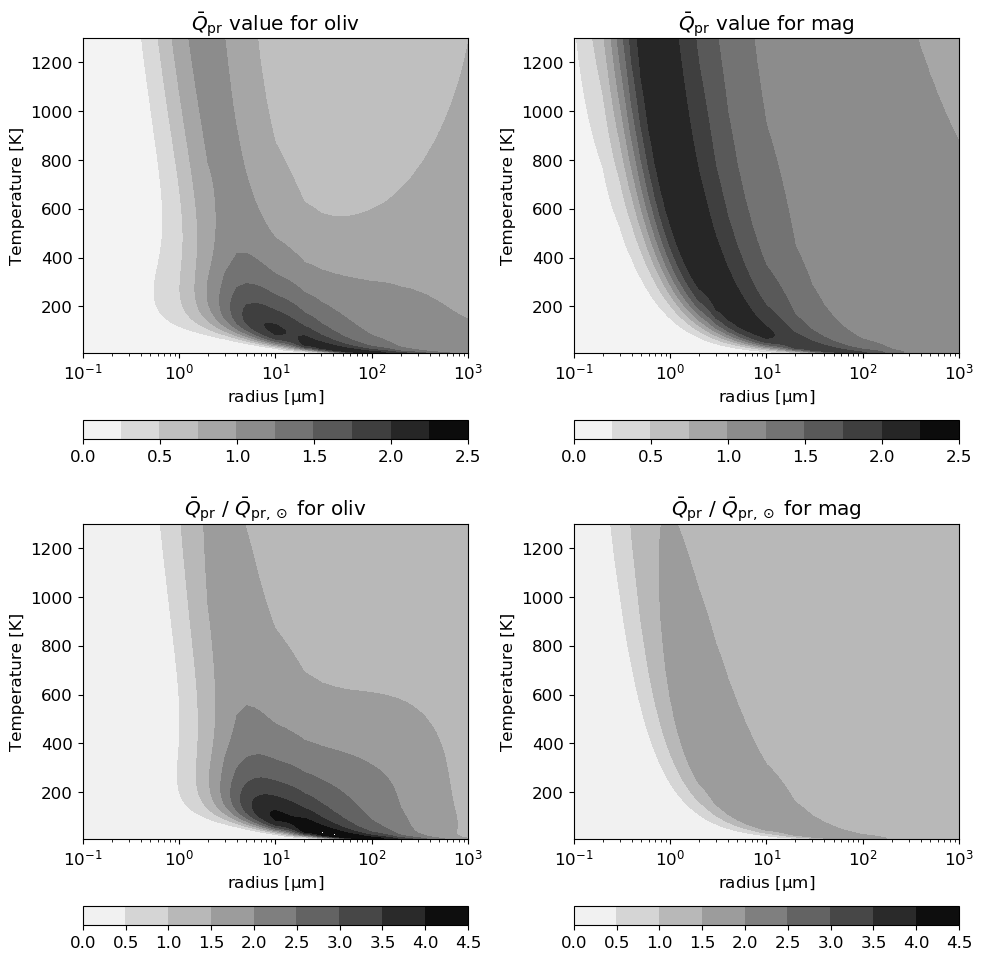

In [11]:
materials = ["oliv", "mag"]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, mat in enumerate(materials):
    ax = axs[0, i]
    axc = axs[1, i]  # c = compared with solar (Qprbar_sun)
    T, Qprbar, r = Qpr_extractor(savedir / f"Qprbar_{mat}.csv", "T")
    _, Qprbar_sun, _ = Qpr_extractor(savedir / f"Qprbar_sun_{mat}.csv", "T")
    r = np.array(r, dtype='float')

    im = ax.contourf(r, T, Qprbar,
                     levels=np.arange(0., 2.6, 0.25), cmap='gray_r')
    cb = fig.colorbar(im, ax=ax, 
                      orientation='horizontal', 
                      format=FormatStrFormatter("%.1f"))

    imc = axc.contourf(r, T, Qprbar / Qprbar_sun,
                       levels=np.arange(0., 5, 0.5), cmap='gray_r')
    cbc = fig.colorbar(imc, ax=axc,
                       orientation='horizontal', 
                       format=FormatStrFormatter("%.1f"))

    ax.set(xscale='log', xlabel=r"radius [$\mathrm{\mu m}$]",
           ylabel="Temperature [K]",
           title=r"$ \bar{{Q}}_\mathrm{{pr}} $ value for {:s}".format(mat))

    axc.set(xscale='log', xlabel=r"radius [$\mathrm{\mu m}$]",
            ylabel="Temperature [K]",
            title=(r"$ \bar{Q}_\mathrm{pr} $"
                   + r" / $ \bar{Q}_\mathrm{pr, \odot} $"
                   + r" for {}".format(mat)))

plt.tight_layout()
plt.savefig(figdir / "Qprbar_2d.pdf")
plt.savefig(figdir / "Qprbar_2d.png", dpi=200)

-----
## 5. Checking $Q_\mathrm{pr}$ and $\bar{Q}_{\mathrm{pr}}$ Values

1. I will plot the $Q_\mathrm{pr}$ value of some selected radii of particles as a function of wavelength. For olivine, plotted for each orientation. For magnetite, there is only one dataset. 
  * ``plotradii = [0.1, 1.0, 2.0, 10, 100]`` in μm
2. Then plot $b_\lambda$ for selected temperatures.
  * ``plot_temps = [c_T_sun, 1000, 300, 100, 10]`` in K
3. Then intuitively show how the $\bar{Q}_\mathrm{pr}$ value can be larger for thermal spectrum than solar spectrum, thus hints the thermal radiation force is larger than solar radiation pressure. 
4. Finally I will show the $\bar{Q}_\mathrm{pr}$ value as a function of particle size for selected temperatures, and check it actually converges to 1 when particle is much larger than wavelengths of interest (geometric optics approximation)
  * ``plot_temps = [c_T_sun, 1000, 300, 100, 10]`` in K

### 5-1. Olivine

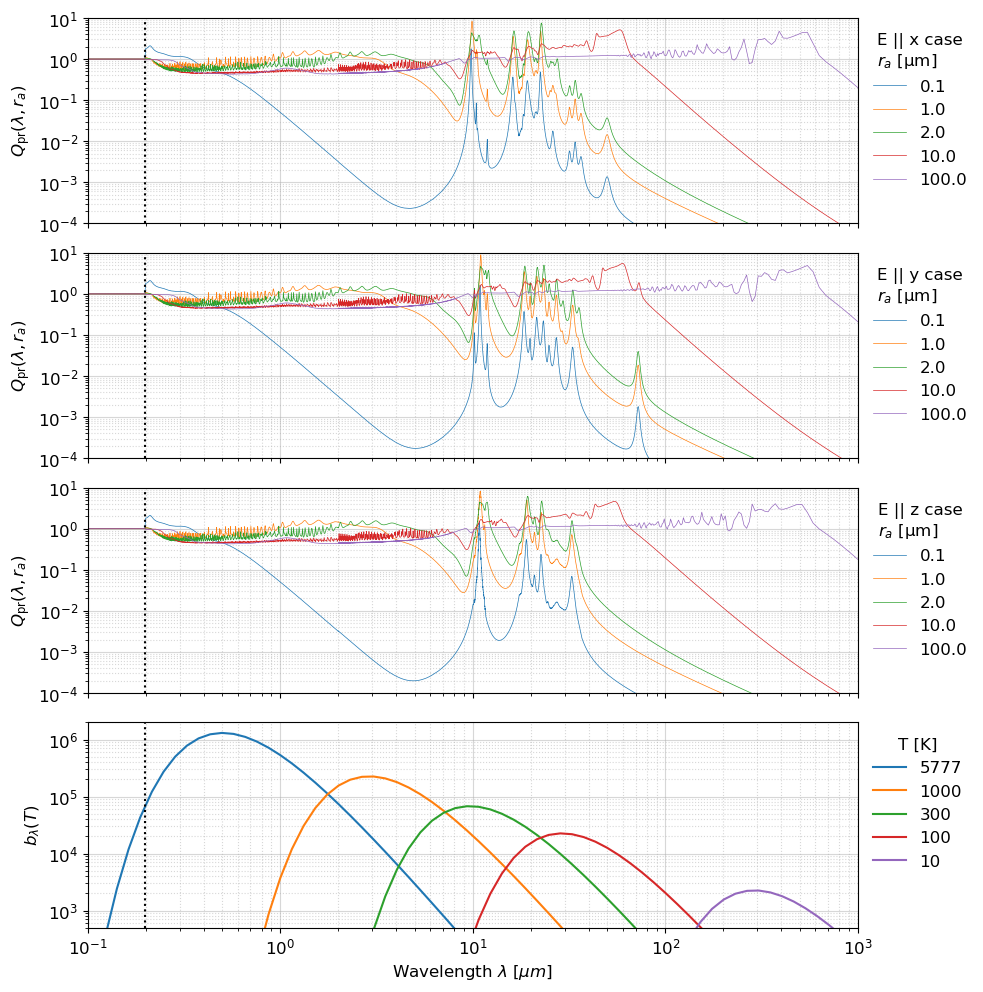

In [12]:
legtitle = (r"E || {} case" + "\n"
            + r"$r_a$ $[\mathrm{{\mu m}}]$")
legkw = dict(framealpha=0, loc=2, bbox_to_anchor=(1,1))

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i, xyz in enumerate(["x", "y", "z"]):
    Qpr_oliv = pd.read_csv(savedir / fname_oliv.format(xyz))
    wl = Qpr_oliv["wavelength"]

    # Plot Qpr (not Qprbar)    
    for r in plotradii:
        axs[i].plot(wl, Qpr_oliv[f"{r:.1f}"], '-', lw=0.5,
                    label=f'{r:.1f}')    
    axs[i].loglog()
    axs[i].set(xlim=(2.e-3, 1.e4), ylim=(1.e-4, 10),
               ylabel=r"$Q_\mathrm{pr}(\lambda, r_a)$")
    axs[i].legend(title=legtitle.format(xyz), **legkw)
    axs[i].axvline(wl_low[-1], ls=':', color='k')

wl4plot = np.logspace(-2, 4, 100)
for T in plot_temps:
    blam = tm.b_lambda(wavelen=wl4plot*c_um, temperature=T)
#     imax = np.argmax(blam)
#     axs[3].annotate(f"{T:.0f} K", xy=(wl4plot[imax] * 1.7, blam[imax] * 0.6))
    axs[3].plot(wl4plot, blam, label=f"{T:.0f}")
axs[3].loglog()
axs[3].legend(title="T [K]", **legkw)
axs[3].axvline(wl_low[-1], ls=':', color='k')

axs[3].set(xlim=(1.e-1, 1.e+3), ylim=(5.e2, 2.e+6),
           xlabel=r"Wavelength $\lambda$ $[\mu m]$",
           ylabel=r"$b_\lambda(T)$")

for i, aa in enumerate(axs.tolist()):
    aa.xaxis.set_major_locator(LogLocator(base=10, subs=[1]))
    aa.yaxis.set_major_locator(LogLocator(base=10, subs=[1]))
    aa.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(10)))
    aa.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(10)))
    aa.grid(which='major', ls='-', alpha=0.5)
    aa.grid(which='minor', ls=':', alpha=0.5)
    
plt.tight_layout()
plt.savefig(figdir / "Qpr_oliv.pdf")
plt.savefig(figdir / "Qpr_oliv.png", dpi=200)

The vertical dotted black line indicates the wavelength where the extrapolation started (leftward).

### 5-2. Magnetite

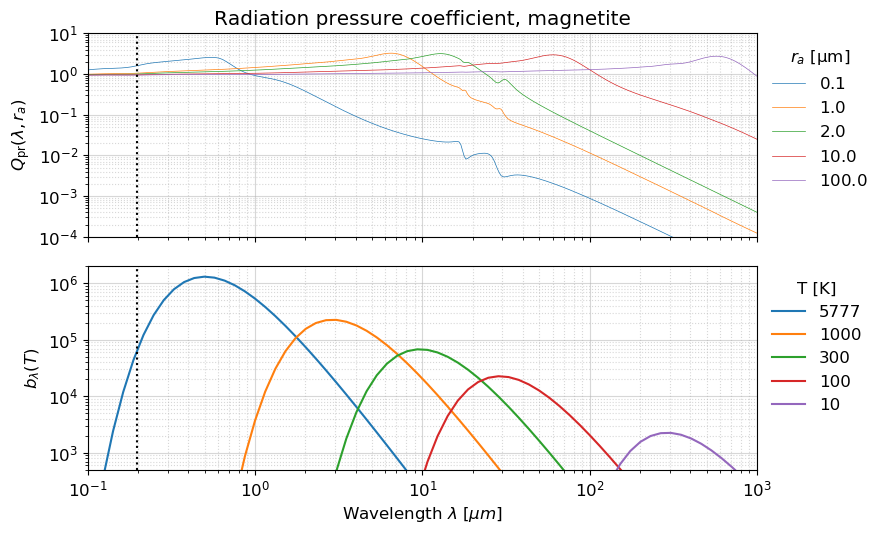

In [13]:
legkw = dict(framealpha=0, loc=2, bbox_to_anchor=(1,1))

Qpr_mag = pd.read_csv(savedir / fname_mag, delimiter=',')
wl = np.array(Qpr_mag["wavelength"])

fig, axs = plt.subplots(2, 1, figsize=(9, 5.5), sharex=True)
# Plot Qpr (not Qprbar)    
for r in plotradii:
    axs[0].plot(wl, Qpr_mag[f"{r:.1f}"], '-', lw=0.5,
                label=r'${:.1f}$'.format(r))    

axs[0].loglog()
axs[0].set(xlim=(2.e-3, 1.e4), 
           ylim=(1.e-4, 10),
           ylabel=r"$Q_\mathrm{pr}(\lambda, r_a)$",
           title="Radiation pressure coefficient, magnetite")
axs[0].legend(title=r"$r_a$ $[\mathrm{\mu m}]$", **legkw)
axs[0].axvline(wl_low[-1], ls=':', color='k')

wl4plot = np.logspace(-2, 4, 100)
for T in plot_temps:
    blam = tm.b_lambda(wavelen=wl4plot*c_um, temperature=T)
#     imax = np.argmax(blam)
#     axs[1].annotate(f"{T:.0f} K", xy=(wl4plot[imax] * 1.7, blam[imax] * 0.6))
    axs[1].plot(wl4plot, blam, label=f"{T:.0f}")
axs[1].loglog()
axs[1].legend(title="T [K]", **legkw)
axs[1].axvline(wl_low[-1], ls=':', color='k')

axs[1].set(xlim=(1.e-1, 1.e+3), ylim=(5.e2, 2.e+6),
           xlabel=r"Wavelength $\lambda$ $[\mu m]$",
           ylabel=r"$b_\lambda(T)$"
          )

for i, aa in enumerate(axs.tolist()):
    aa.xaxis.set_major_locator(LogLocator(base=10, subs=[1]))
    aa.yaxis.set_major_locator(LogLocator(base=10, subs=[1]))
    aa.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(10)))
    aa.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(10)))
    aa.grid(which='major', ls='-', alpha=0.5)
    aa.grid(which='minor', ls=':', alpha=0.5)

plt.tight_layout()
plt.savefig(figdir / "Qpr_mag.pdf")
plt.savefig(figdir / "Qpr_mag.png", dpi=200)

### 5-3. How can $\bar{Q}_\mathrm{pr} (T = T_{S}) > \bar{Q}_\mathrm{pr}(T = T_{\odot})$?

To validate that it is actually possible that the $\bar{Q}_\mathrm{pr}$ value (**not** $\bar{Q}_\mathrm{pr}$ value!) can be larger for thermal spectrum than solar spectrum, let's plot the $ Q_\mathrm{pr} \times b_\lambda $ as a function of wavelength. The integration of this curve is the $ \bar{Q}_\mathrm{pr} $.

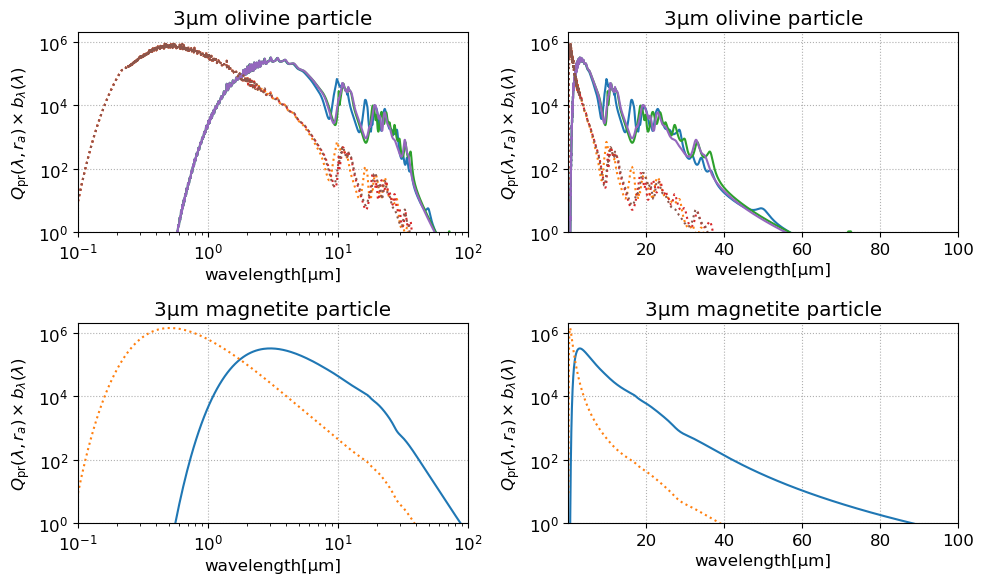

In [14]:
def testplot(datapath, ax_linear, ax_log, r=3.0):
    data = pd.read_csv(datapath)
    wl = np.array(data["wavelength"])
    Qpr = np.array(data[f"{r:.1f}"].values)
    blam = tm.b_lambda(wl*c_um, 1000)
    bQpr_1000 = blam * Qpr
    blam = tm.b_lambda(wl*c_um, 5777)
    bQpr_5777 = blam * Qpr
    
    ax_log.set_xscale('log')
    for ax in [ax_linear, ax_log]:
        ax.plot(wl, bQpr_1000)
        ax.plot(wl, bQpr_5777, ls=":")
        ax.set(yscale='log', 
               xlim=(1.e-1, 1.e+2), ylim=(1.e+0, 2.e+6), 
               xlabel="wavelength[μm]", 
               ylabel=r"$Q_\mathrm{pr}(\lambda, r_a) \times b_\lambda(\lambda)$")
        ax.grid(ls=':')

    
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axo1, axo2 = axs[0, 0], axs[0, 1]
axm1, axm2 = axs[1, 0], axs[1, 1]
axo1.set_title("3μm olivine particle")
axo2.set_title("3μm olivine particle")
axm1.set_title("3μm magnetite particle")
axm2.set_title("3μm magnetite particle")

for i, xyz in enumerate(["x", "y", "z"]):
    testplot(savedir / fname_oliv.format(xyz), axo2, axo1, r=3.)

testplot(savedir / fname_mag, axm2, axm1, r=3.)

plt.tight_layout()

Solid line = 1000 K, dotted line = 5777 K, and each has three components (olivine has three (x, y, z) orientations).

Note that the log-scale representation of the x-axis (as in the left) delude us that the integrated value of solar spectrum would be larger. But in the linear scale (as in the right), the 1000K spectrum case is orders of magnitude larger over nearly all the wavelength. Therefore, it is not trivial at this moment which area will be larger. And below, we can see that acutally the area from 1000K is larger by factor of around 2 (for both olivine and magnetite).

### 5-4. Orientations of Olivine

Olivine has three different measurements based on the polarizations. Here I show that the difference in the $\bar{Q}_\mathrm{pr}$ value is not significant. Thus, I have used the average value of the three different orientations as _the_ $\bar{Q}_\mathrm{pr}$ value of olivine at the given size.

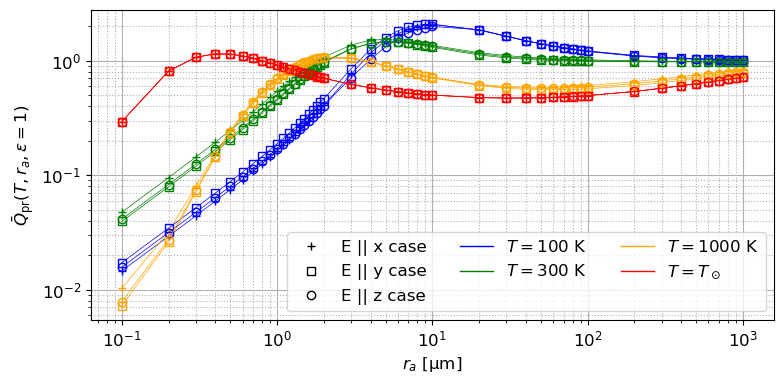

In [15]:
marker_xyz = {"x": dict(marker="+"),
              "y": dict(marker="s", mfc='none'),
              "z": dict(marker="o", mfc='none')}

color_temp = {100:"b",
              300:"g",
              1000:"orange"}

fig, ax = plt.subplots(1, 1, figsize=(8, 4))#, sharex=True)

for xyz in ["x", "y", "z"]:
    Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_oliv_{xyz}.csv", skiprows=1, delimiter=',')
    Qprbar = pd.read_csv(savedir / f"Qprbar_oliv_{xyz}.csv")
    Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

    for i, (_, row) in enumerate(Qprbar.iterrows()):
        T = row["T"]
        try:
            c = color_temp[T]
        except KeyError:
            continue
        ax.plot(radii, row.values[1:], ls="-", lw=0.5,
                **marker_xyz[xyz], color=c)

    ax.plot([0], [0], color="k", ls='', **marker_xyz[xyz], 
            label=f"E || {xyz} case")
    ax.plot(radii, Qprbar_sun[1:], ls="-", lw=0.5, **marker_xyz[xyz], color="r")

for k, v in color_temp.items():
    ax.plot([0], [0], ls="-", lw=1, color=v, label=r"$T = {}$ K".format(k))
ax.plot([0], [0], ls="-", lw=1, color="r", label=r"$T = T_\odot$")

ax.loglog()
ax.set(xlabel=r"$r_a$ $\mathrm{[\mu m]}$", 
       ylabel=r"$\bar{Q}_\mathrm{pr}(T, r_a, \epsilon=1)$")
ax.grid(which="major", ls='-')
ax.grid(which="minor", ls=':')
ax.legend(ncol=3)
plt.tight_layout()

plt.savefig(figdir / "Qpr_oliv_comp_xyz.pdf")
plt.savefig(figdir / "Qpr_oliv_comp_xyz.png", dpi=200)

As can be seen, the x/y/z directionality does give some difference, but is nearly ignorable in all cases. For simplicity, I used the averaged $\bar{Q}_\mathrm{pr}$ values, i.e., $ \bar{Q}_\mathrm{pr} = (\bar{Q}_{\mathrm{pr}, x} + \bar{Q}_{\mathrm{pr}, y} + \bar{Q}_{\mathrm{pr}, z}) / 3 $.

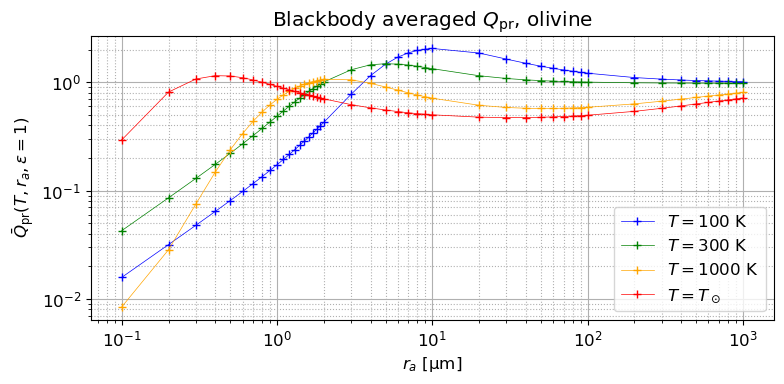

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))#, sharex=True)

Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_oliv.csv", skiprows=1, delimiter=',')
Qprbar = pd.read_csv(savedir / f"Qprbar_oliv.csv")
Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

for i, (_, row) in enumerate(Qprbar.iterrows()):
    T = row["T"]
    try:
        c = color_temp[T]
    except KeyError:
        continue
    ax.plot(radii, row.values[1:], "+-", lw=0.5, color=c, label=r"$T = {:.0f}$ K".format(T))

ax.plot(radii, Qprbar_sun[1:], "+-", lw=0.5, color="r", label=r"$T = T_\odot $")

ax.loglog()
ax.set(xlabel=r"$r_a$ $\mathrm{[\mu m]}$", 
       ylabel=r"$\bar{Q}_\mathrm{pr}(T, r_a, \epsilon=1)$",
       title="Blackbody averaged $Q_\mathrm{pr}$, olivine")
ax.grid(which="major", ls='-')
ax.grid(which="minor", ls=':')
ax.legend(ncol=1)
plt.tight_layout()

plt.savefig(figdir / "Qpr_oliv_comp.pdf")
plt.savefig(figdir / "Qpr_oliv_comp.png", dpi=200)

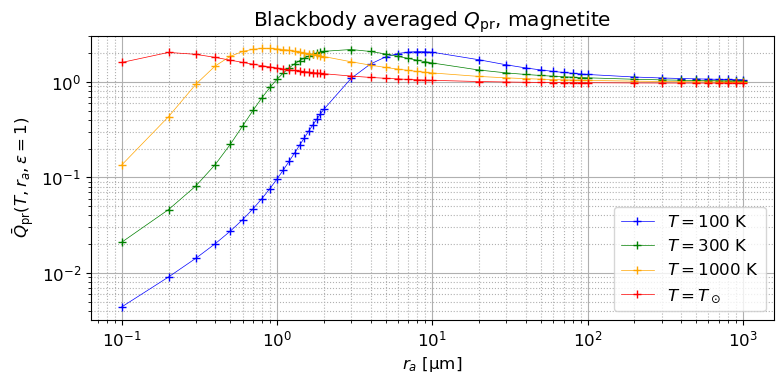

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_mag.csv", skiprows=1, delimiter=',')
Qprbar = pd.read_csv(savedir / f"Qprbar_mag.csv")
Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

for i, (_, row) in enumerate(Qprbar.iterrows()):
    T = row["T"]
    try:
        c = color_temp[T]
    except KeyError:
        continue
    ax.plot(radii, row.values[1:], "+-", lw=0.5, color=c, label=r"$T = {:.0f}$ K".format(T))

ax.plot(radii, Qprbar_sun[1:], "+-", lw=0.5, color="r", label=r"$T = T_\odot $")

ax.loglog()
ax.set(xlabel=r"$r_a$ $\mathrm{[\mu m]}$", 
       ylabel=r"$\bar{Q}_\mathrm{pr}(T, r_a, \epsilon=1)$",
       title=r"Blackbody averaged $Q_\mathrm{pr}$, magnetite")
ax.grid(which="major", ls='-')
ax.grid(which="minor", ls=':')
ax.legend(ncol=1)
plt.tight_layout()

plt.savefig(figdir / "Qpr_mag_comp.pdf")
plt.savefig(figdir / "Qpr_mag_comp.png", dpi=200)

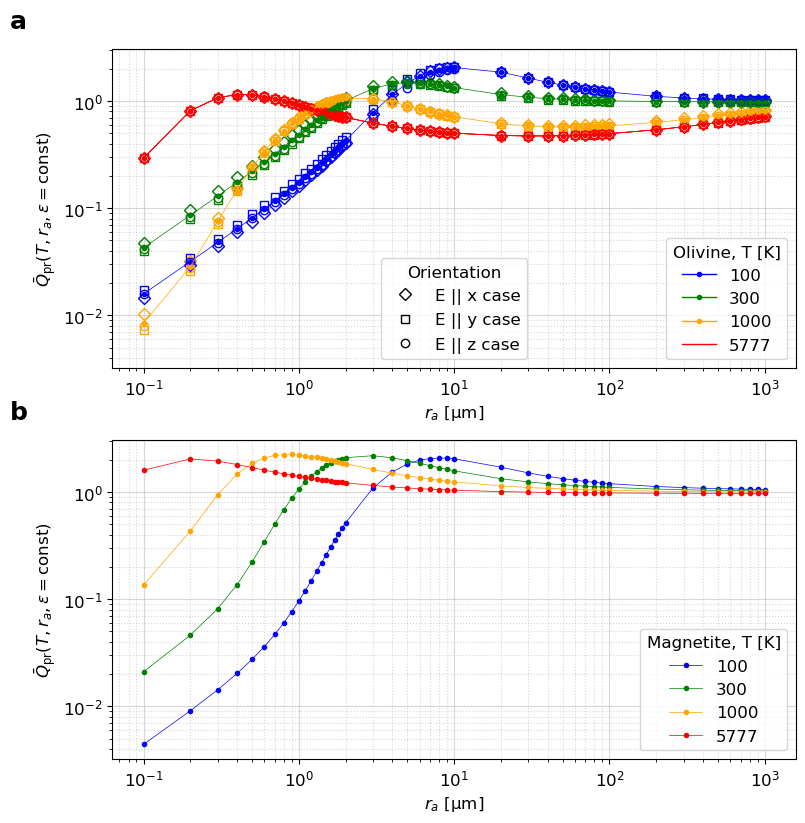

In [4]:
marker_xyz = {"x": dict(marker="D", mfc='none'),
              "y": dict(marker="s", mfc='none'),
              "z": dict(marker="o", mfc='none')}

color_temp = {100:"b",
              300:"g",
              1000:"orange"}
dummy_pos = ([np.nan], [np.nan])
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharey=True)#, sharex=True)
ax_3 = axs[0]
ax_m = axs[1]

for xyz in ["x", "y", "z"]:
    Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_oliv_{xyz}.csv", skiprows=1, delimiter=',')
    Qprbar = pd.read_csv(savedir / f"Qprbar_oliv_{xyz}.csv")
    Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

    for i, (_, row) in enumerate(Qprbar.iterrows()):
        T = row["T"]
        try:
            c = color_temp[T]
        except KeyError:
            continue
        ax_3.plot(radii, row.values[1:], ls="", lw=0.5,
                  **marker_xyz[xyz], color=c)

    ax_3.plot(*dummy_pos, color="k", ls='', **marker_xyz[xyz], 
              label=f"E || {xyz} case")
    ax_3.plot(radii, Qprbar_sun[1:], ls="-", lw=0.5, **marker_xyz[xyz], color="r")

ax_dummy = ax_3.twinx()
ax_dummy.axis('off')

for k, v in color_temp.items():
    ax_dummy.plot(*dummy_pos, ".-", lw=1, color=v, label=k)
ax_dummy.plot(*dummy_pos, ls="-", lw=1, color="r", label=c_T_sun)

ax_3.set(xlabel=r"$r_a$ $\mathrm{[\mu m]}$", 
         ylabel=r"$\bar{Q}_\mathrm{pr}(T, r_a, \epsilon=\mathrm{const})$",
         xscale='log', yscale='log')
ax_3.legend(loc='lower center', ncol=1, title="Orientation")
ax_dummy.legend(loc=4, title="Olivine, T [K]")

Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_oliv.csv", skiprows=1, delimiter=',')
Qprbar = pd.read_csv(savedir / f"Qprbar_oliv.csv")
Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

for i, (_, row) in enumerate(Qprbar.iterrows()):
    T = row["T"]
    try:
        c = color_temp[T]
    except KeyError:
        continue
    ax_3.plot(radii, row.values[1:], ".-", lw=0.5, color=c, label=r"$T = {:.0f}$ K".format(T))

ax_3.plot(radii, Qprbar_sun[1:], ".-", lw=0.5, color="r", label=r"$T = T_\odot $")


Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_mag.csv", skiprows=1, delimiter=',')
Qprbar = pd.read_csv(savedir / f"Qprbar_mag.csv")
Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

for i, (_, row) in enumerate(Qprbar.iterrows()):
    T = row["T"]
    try:
        c = color_temp[T]
    except KeyError:
        continue
    ax_m.plot(radii, row.values[1:], ".-", lw=0.5, color=c, label=f"{T:.0f}")

ax_m.plot(radii, Qprbar_sun[1:], ".-", lw=0.5, color="r", label=c_T_sun)
ax_m.set(xlabel=r"$r_a$ $\mathrm{[\mu m]}$", 
         ylabel=r"$\bar{Q}_\mathrm{pr}(T, r_a, \epsilon=\mathrm{const})$",
         xscale='log', yscale='log')
ax_m.legend(loc=4, title="Magnetite, T [K]")
plt.tight_layout()

logticker(axs)

for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.15, y=1.05, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

plt.savefig(figdir / "Qpr_oliv_mag_comp.pdf")
plt.savefig(figdir / "Qpr_oliv_mag_comp.png", dpi=300)

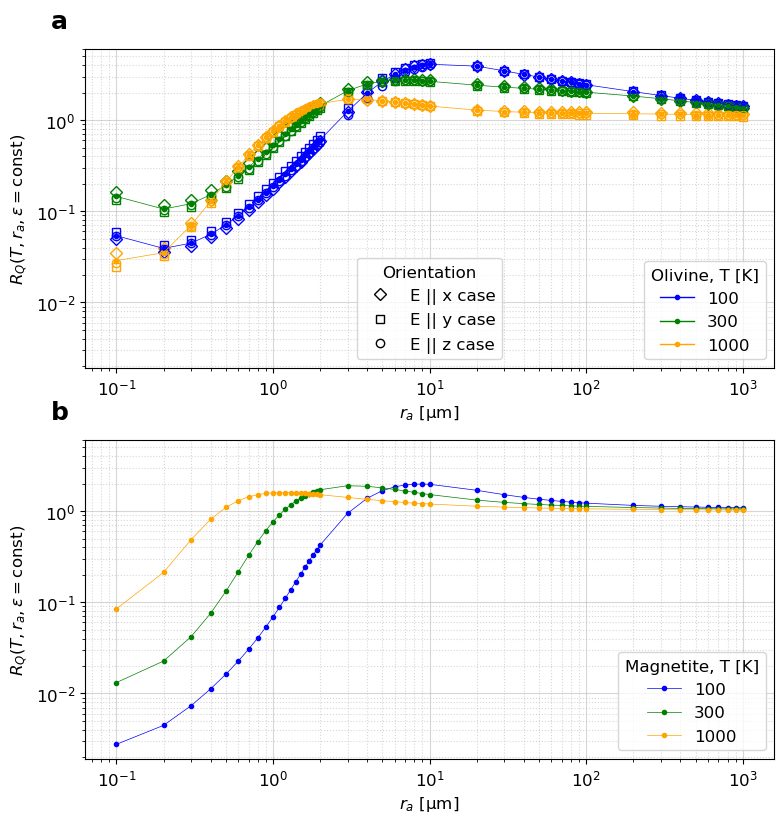

In [9]:
marker_xyz = {"x": dict(marker="D", mfc='none'),
              "y": dict(marker="s", mfc='none'),
              "z": dict(marker="o", mfc='none')}

color_temp = {100:"b",
              300:"g",
              1000:"orange"}
dummy_pos = ([np.nan], [np.nan])
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharey=True)#, sharex=True)
ax_3 = axs[0]
ax_m = axs[1]

for xyz in ["x", "y", "z"]:
    Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_oliv_{xyz}.csv", skiprows=1, delimiter=',')
    Qprbar = pd.read_csv(savedir / f"Qprbar_oliv_{xyz}.csv")
    Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

    for i, (_, row) in enumerate(Qprbar.iterrows()):
        T = row["T"]
        try:
            c = color_temp[T]
        except KeyError:
            continue
        ax_3.plot(radii, row.values[1:]/Qprbar_sun[1:], ls="", lw=0.5,
                  **marker_xyz[xyz], color=c)

    ax_3.plot(*dummy_pos, color="k", ls='', **marker_xyz[xyz], 
              label=f"E || {xyz} case")

ax_dummy = ax_3.twinx()
ax_dummy.axis('off')

for k, v in color_temp.items():
    ax_dummy.plot(*dummy_pos, ".-", lw=1, color=v, label=k)

ax_3.set(xlabel=r"$r_a$ $\mathrm{[\mu m]}$", 
         ylabel=r"$R_Q(T, r_a, \epsilon=\mathrm{const})$",
         xscale='log', yscale='log')
ax_3.legend(loc='lower center', ncol=1, title="Orientation")
ax_dummy.legend(loc=4, title="Olivine, T [K]")

Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_oliv.csv", skiprows=1, delimiter=',')
Qprbar = pd.read_csv(savedir / f"Qprbar_oliv.csv")
Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

for i, (_, row) in enumerate(Qprbar.iterrows()):
    T = row["T"]
    try:
        c = color_temp[T]
    except KeyError:
        continue
    ax_3.plot(radii, row.values[1:]/Qprbar_sun[1:], ".-", lw=0.5, color=c, label=r"$T = {:.0f}$ K".format(T))


Qprbar_sun = np.loadtxt(savedir / f"Qprbar_sun_mag.csv", skiprows=1, delimiter=',')
Qprbar = pd.read_csv(savedir / f"Qprbar_mag.csv")
Qprbar = Qprbar[Qprbar["T"].isin(plot_temps)]

for i, (_, row) in enumerate(Qprbar.iterrows()):
    T = row["T"]
    try:
        c = color_temp[T]
    except KeyError:
        continue
    ax_m.plot(radii, row.values[1:]/Qprbar_sun[1:], ".-", lw=0.5, color=c, label=f"{T:.0f}")

ax_m.set(xlabel=r"$r_a$ $\mathrm{[\mu m]}$", 
         ylabel=r"$R_Q(T, r_a, \epsilon=\mathrm{const})$",
         xscale='log', yscale='log')
ax_m.legend(loc=4, title="Magnetite, T [K]")
plt.tight_layout()

logticker(axs)

for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.05, y=1.05, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')


plt.savefig(figdir / "Qpr_RQ_oliv_mag_comp.pdf", bbox_inches="tight")
plt.savefig(figdir / "Qpr_RQ_oliv_mag_comp.png", dpi=300, bbox_inches="tight")